In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from metpy.units import units
from datetime import timedelta

In [2]:
def getNewLatLon(lat, lon, bearing, distance):
    """
    Calcualtes a new lat, lon pair from bearing and distance
    """
    # Average radius of the earth
    earth_r = 6371 * units.km

    originLatInRadians = math.radians(lat)
    originLonInRadians = math.radians(lon)
    angularDistance = distance.to('km').magnitude / earth_r.magnitude
    bearingInRadians = math.radians(bearing)

    # Calculate new latitude
    new_lat = math.asin(math.sin(originLatInRadians) * math.cos(angularDistance) + math.cos(originLatInRadians) * 
                                 math.sin(angularDistance) * math.cos(bearingInRadians))

    # Calculate new longitude
    new_lon = originLonInRadians + math.atan2(math.sin(bearingInRadians) * math.sin(angularDistance) * 
                                                       math.cos(originLatInRadians), math.cos(angularDistance) - math.sin(originLatInRadians) * math.sin(new_lat))
    # Convert from radians to degrees
    new_lon = math.degrees(new_lon)
    new_lat = math.degrees(new_lat)

    return (new_lon, new_lat)

In [3]:
def distanceBetweenPoints(lat1, lon1, lat2, lon2, unit='km'):
    """
    Haversine formula to calculate the great-circle distance between two points
    """
    # Average radius of the earth
    earth_r = 6371 * units.km

    # Get lat lon pairs in radians
    lat1, lon1 = math.radians(lat1), math.radians(lon1)
    lat2, lon2 = math.radians(lat2), math.radians(lon2)

    # Get delta lat lon
    deltaLat = lat2-lat1
    deltaLon = lon2-lon1

    a = math.sin(deltaLat/2) * math.sin(deltaLat/2) + math.cos(lat1) * math.cos(lat2) * math.sin(deltaLon/2) * math.sin(deltaLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    return (earth_r * c).to(units(unit))

In [4]:
def build_local_db(db, local_lat, local_lon, max_d):
    """
    Generate a local database of severe reports from main SPC database
    """
    # Initilize local database
    db_local = pd.DataFrame(columns=db.columns)

    # Calculate extent
    n_extent = getNewLatLon(local_lat, local_lon, 360, max_d)[1]
    s_extent = getNewLatLon(local_lat, local_lon, 180, max_d)[1]
    e_extent = getNewLatLon(local_lat, local_lon, 90, max_d)[0]
    w_extent = getNewLatLon(local_lat, local_lon, 270, max_d)[0]
    
    # Subset database based on on extent box
    db = db.loc[(db.slat >= s_extent) & (db.slat <= n_extent) & (db.slon >= w_extent) & (db.slon <= e_extent)]
    
    # Get local LSRs within radius
    for index, lsr in db.iterrows():
        
        # Get distance of lat lon pair
        d = distanceBetweenPoints(local_lat, local_lon, lsr.slat, lsr.slon)

        # Check if within acceptable range
        if d <= max_distance:
            db_local = db_local.append(lsr)
            
    # Set data types
    db_local = db_local.astype({'yr': 'int32'})
    db_local = db_local.astype({'mo': 'int32'})
    db_local = db_local.astype({'dy': 'int32'})
    db_local = db_local.astype({'mag': 'float64'})
    
    # Convert time from CST (UTC-6) to UTC
    db_local.time = pd.to_datetime(db_local.time, format='%H:%M:%S')
    db_local.time = db_local.time + timedelta(hours=6)
    
    # Bin time based on hour
    db_local.time = db_local.time.dt.hour
    
    return db_local

In [2]:
def download_era5(analysisTime):
    """
    Download ERA5 reanalysis for a given data and time
    """
    # Build file path
    outpath = f'/home/pi/workspace/Local-Severe-Weather-Stats/data/era5/era5-reanalysis_{analysisTime:%Y%m%d_%H%M}.nc'
    
    # Check if file exists
    if isfile(outpath) == False:
    
        # Start CDS API client
        c = cdsapi.Client()

        # Make CDS API request for ERA5 reanalysis
        c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            'geopotential', 'relative_humidity', 'temperature',
            'u_component_of_wind', 'v_component_of_wind',
        ],
        'pressure_level': [
            '100', '125', '150',
            '175', '200', '225',
            '250', '300', '350',
            '400', '450', '500',
            '550', '600', '650',
            '700', '750', '775',
            '800', '825', '850',
            '875', '900', '925',
            '950', '975', '1000',
        ],
        'year': f'{analysisTime:%Y}',
        'month': f'{analysisTime:%m}',
        'day': f'{analysisTime:%d}',
        'time': f'{analysisTime:%H:%M}',
        'area': [80.24, -149.06, 15.28, -47.81],
    }, outpath)

In [1]:
def get_db_reanalysis(db):
    """
    Downloads ERA5 reanalysis dataset for each event in dataset
    """
    for year, month, day, hour in zip(db.yr, db.mo, db.dy, db.time):

        eventTime = datetime(year, month, day, hour)

        download_era5(eventTime)

In [5]:
latitude  = 42.38
longitude = -76.87
max_distance = 50 * units.km

In [6]:
# Load Tornado LSR data
tor = pd.read_csv('data/1950-2019_torn.csv')
tor = tor[['yr', 'mo', 'dy', 'time', 'mag', 'slat', 'slon', 'elat', 'elon']]

# Load Hail LSR data
hail = pd.read_csv('data/1955-2019_hail.csv')
hail = hail[['yr', 'mo', 'dy', 'time', 'mag', 'slat', 'slon', 'elat', 'elon']]

# Load Wind LSR data
wind = pd.read_csv('data/1955-2019_wind.csv')
wind = wind[['yr', 'mo', 'dy', 'time', 'mag', 'slat', 'slon', 'elat', 'elon']]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# Get local Tornado LSR data
tor_local = build_local_db(tor, latitude, longitude, max_distance)
tor_local[['mo', 'dy', 'time', 'mag']].describe()

,mo,dy,time,mag
count,27.000000,27.000000,27.000000,27.000000
mean,6.814815,18.777778,14.851852,1.111111
std,1.641693,9.814955,8.356037,0.697982
min,4.000000,1.000000,0.000000,0.000000
25%,6.000000,13.500000,9.000000,1.000000
50%,7.000000,21.000000,19.000000,1.000000
75%,8.000000,27.000000,20.500000,1.000000
max,11.000000,30.000000,23.000000,3.000000


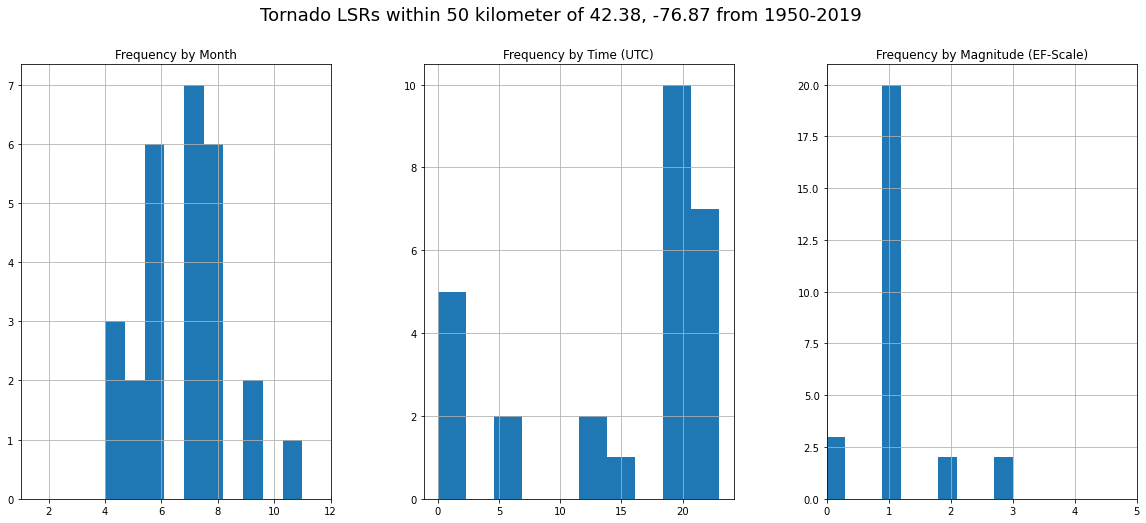

In [8]:
# Create plot for Tornado LSR data
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))


tor_local.hist('mo', ax=ax0)
tor_local.hist('time', ax=ax1)
tor_local.hist('mag', ax=ax2)

ax0.set_title('Frequency by Month')
ax0.set_xlim(1, 12)

ax1.set_title('Frequency by Time (UTC)')
ax2.set_xlim(0, 23)

ax2.set_title('Frequency by Magnitude (EF-Scale)')
ax2.set_xlim(0, 5)

plt.suptitle(f'Tornado LSRs within {max_distance} of {latitude}, {longitude} from 1950-2019', size=18)

plt.show()

In [9]:
# Get local Hail LSR data
hail_local = build_local_db(hail, latitude, longitude, max_distance)
hail_local[['mo', 'dy', 'time', 'mag']].describe()

,mo,dy,time,mag
count,353.000000,353.000000,353.000000,353.000000
mean,6.464589,15.821530,17.560907,1.047932
std,1.362867,8.906356,6.365064,0.338838
min,4.000000,1.000000,0.000000,0.750000
25%,5.000000,7.000000,17.000000,0.750000
50%,6.000000,16.000000,20.000000,1.000000
75%,7.000000,24.000000,21.000000,1.000000
max,11.000000,31.000000,23.000000,2.500000


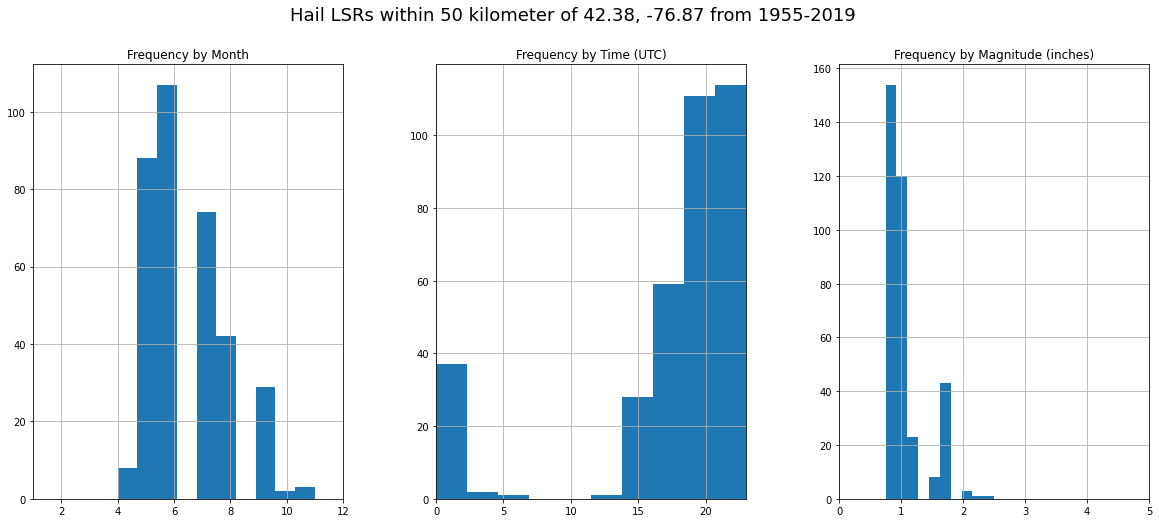

In [10]:
# Create plot for Hail LSR data
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

hail_local.hist('mo', ax=ax0)
hail_local.hist('time', ax=ax1)
hail_local.hist('mag', ax=ax2)

ax0.set_title('Frequency by Month')
ax0.set_xlim(1, 12)

ax1.set_title('Frequency by Time (UTC)')
ax1.set_xlim(0, 23)

ax2.set_title('Frequency by Magnitude (inches)')
ax2.set_xlim(0, 5)

plt.suptitle(f'Hail LSRs within {max_distance} of {latitude}, {longitude} from 1955-2019', size=18)

plt.show()

In [11]:
# Get local Wind LSR data
wind_local = build_local_db(wind, latitude, longitude, max_distance)
wind_local[['mo', 'dy', 'time', 'mag']].describe()

,mo,dy,time,mag
count,842.000000,842.000000,842.000000,842.000000
mean,6.789786,17.150831,17.134204,33.103325
std,1.546655,8.764310,6.913929,25.379592
min,1.000000,1.000000,0.000000,0.000000
25%,6.000000,10.000000,17.000000,0.000000
50%,7.000000,17.000000,20.000000,50.000000
75%,8.000000,25.000000,21.000000,50.000000
max,12.000000,31.000000,23.000000,87.000000


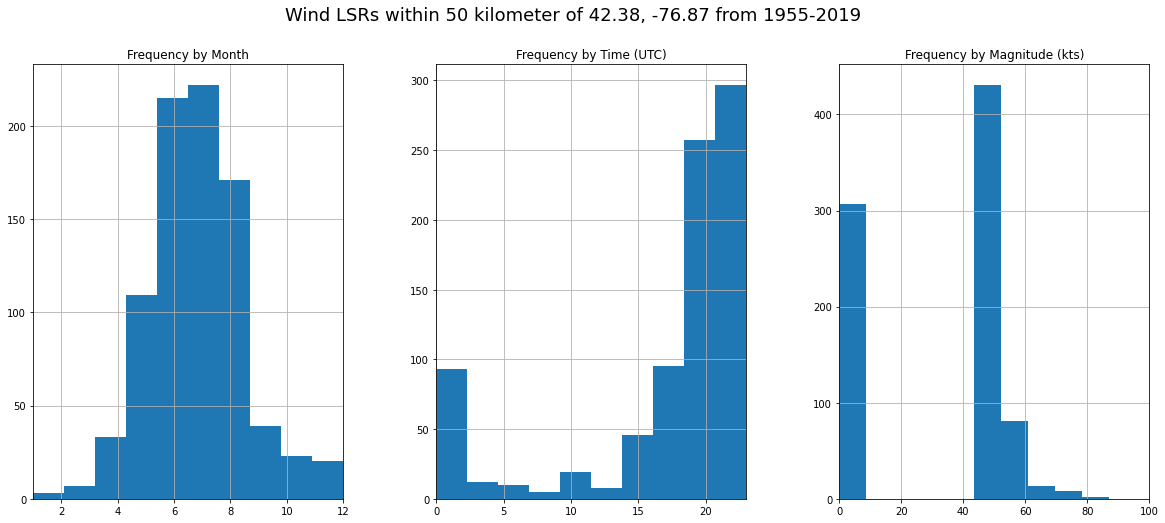

In [12]:
# Create plot for Wind LSR data
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

wind_local.hist('mo', ax=ax0)
wind_local.hist('time', ax=ax1)
wind_local.hist('mag', ax=ax2)

ax0.set_title('Frequency by Month')
ax0.set_xlim(1, 12)

ax1.set_title('Frequency by Time (UTC)')
ax1.set_xlim(0, 23)

ax2.set_title('Frequency by Magnitude (kts)')
ax2.set_xlim(0, 100)

plt.suptitle(f'Wind LSRs within {max_distance} of {latitude}, {longitude} from 1955-2019', size=18)

plt.show()

In [ ]:
# Get ERA5 reanalysis data for local Tornado LSRs
get_db_reanalysis(tor_local)

In [ ]:
# Get ERA5 reanalysis data for local Hail LSRs
get_db_reanalysis(hail_local)

In [ ]:
# Get ERA5 reanalysis data for local Wind LSRs
get_db_reanalysis(wind_local)